# 56 Days BP Data
* GAN用の14日間分のデータを用意する: SBP,DBP,PUL (3 dim) 

In [1]:
import mojimoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

## Reading Data

In [2]:
df_bp = pd.read_csv(
    r'/home/hiroshi_koshimizu/work/dataset/P005_BpData_180424.csv', 
    encoding = 'shift-jis', 
    engine = 'python',
    index_col = 'Unnamed: 0'
)

## Convert String

In [3]:
df_bp['Name'] = df_bp['Name'].map(lambda string: mojimoji.zen_to_han(string))
df_bp['Name'] = df_bp['Name'].map(lambda string: string.replace('･', '/'))
df_bp['Date'] = pd.DatetimeIndex(df_bp['Date'])
df_bp['Month'] = df_bp['Date'].map(lambda date:date.month)
df_bp['Week'] = df_bp['Date'].map(lambda date:date.week)
df_bp['Time'] = df_bp['Time'].map(lambda x :pd.to_datetime(x).time())

## Delete useless colomns

In [4]:
df_bp.columns

Index(['Name', 'Birth', 'Age', 'Sex', 'Date', 'Time', 'Type', 'SBP', 'DBP',
       'PUL', 'Fit', 'Move', 'Temp', 'Irr.PUL', 'Check', 'Meas_Time', 'Month',
       'Week'],
      dtype='object')

In [5]:
df_bp = df_bp.drop(['Birth', 'Age', 'Sex', 'Fit', 'Move', 'Check', 'Irr.PUL', 'Meas_Time', 'Week', 'Month'], axis = 1)

## Extract Type

In [6]:
#血圧情報の時間単位のME判定
def ml_bpdata_mejudge(dataframe, start = [[],[]], end = [[],[]]):
    import datetime
    tmp = dataframe.copy()
    tmp['Type'] = None
    
    #Type Mを振りなおし
    flag = np.logical_and(
        tmp['Time'] >= datetime.time(start[0][0],start[0][1], start[0][2]),
        tmp['Time'] < datetime.time(end[0][0],end[0][1], end[0][2])
    )
    tmp.loc[flag, 'Type'] = 'M'
    
    #Type Eを振り直し
    flag = np.logical_or(
        tmp['Time'] >= datetime.time(start[1][0],start[1][1], start[1][2]),
        tmp['Time'] < datetime.time(end[1][0],end[1][1], end[1][2])
    )
    tmp.loc[flag, 'Type'] = 'E'
    
    tmp = tmp[np.logical_or(tmp['Type'] == 'M', tmp['Type'] == 'E')]
    
    return tmp.reset_index(drop = True)
#晩測定の時間シフト
def ml_bpdata_eshift(dataframe, e_end_time):
    import datetime
    tmp = dataframe.copy()
    flag = tmp['Time'] < datetime.time(e_end_time[0],e_end_time[1],e_end_time[2])
    tmp.loc[flag,'Date'] = tmp.loc[flag, 'Date'] - datetime.timedelta(days = 1)
    tmp['Time'] = tmp['Time'].map(lambda x:x.hour)
    tmp_time = tmp.loc[tmp['Time'] < 2, 'Time'].copy()
    #24時間異常表現
    tmp.loc[tmp['Time'] < 2, 'Time'] = tmp_time + 24
    return tmp.reset_index(drop = True)

In [7]:
test_tmp = ml_bpdata_mejudge(df_bp, start = [[4,0,0],[18,0,0]], end = [[12,0,0],[2,0,0]])
test_tmp = ml_bpdata_eshift(test_tmp, e_end_time = [2,0,0])

In [8]:
#MEデータのみする
test_e = test_tmp[test_tmp['Type']== 'E']
test_m = test_tmp[test_tmp['Type']== 'M']

In [9]:
#MEデータ抽出物
def gen_dayme_data(df, name, me_type = 'M' ):
    tmp = df[df['Name'] == name].copy().reset_index(drop = True)
    if me_type == 'M':
        df_list = map( lambda x: tmp[tmp['Date']==x][:2], tmp['Date'].unique() )
    else:
        df_list = map( lambda x: tmp[tmp['Date']==x][-2:], tmp['Date'].unique())
    return pd.concat(df_list, axis = 0)

In [10]:
#晩抽出
test_e = pd.concat(
    list(
        map( 
            lambda x : gen_dayme_data(test_e, x, me_type = 'E'), 
            test_e['Name'].unique() 
        )
    ), 
    axis = 0
)

#朝抽出
test_m = pd.concat(
    list(
        map(
            lambda x : gen_dayme_data(test_m, x, me_type = 'M'),
            test_m['Name'].unique() 
        )
    ), 
    axis = 0
)

In [11]:
test_all = pd.concat([test_e, test_m], axis = 0).drop(['Time', 'Temp'], axis = 1)

## Group by

In [12]:
test_all = pd.pivot_table(
    data = test_all, 
    index = ['Name','Date'],
    columns = ['Type'],
    aggfunc = np.mean
)
test_all.columns = ['_'.join(col_i) for col_i in test_all.columns]
test_all.reset_index(inplace = True)

In [13]:
def make_fill(df, name):
    tmp = df[df['Name'].isin([name])].copy()
    tmp = tmp.set_index('Date')
    tmp = tmp.resample('D').mean().fillna(method='ffill')
    tmp['Name'] = name
    return tmp

def make_fill(df, name):
    tmp = df[df['Name'].isin([name])].copy()
    tmp = tmp.set_index('Date')
    tmp = tmp.resample('D').mean().fillna(method='ffill')
    tmp['Name'] = name
    return tmp

In [14]:
test_all = pd.concat(
    list(
        map(lambda x: make_fill(test_all, x), test_all['Name'].unique())
    )
).reset_index().dropna()

In [15]:
test_all

,Date,DBP_E,DBP_M,PUL_E,PUL_M,SBP_E,SBP_M,Name
1,2015-01-28,76.5,85.0,71.5,69.0,130.0,155.5,N/Predict 0001
2,2015-01-29,86.5,90.5,71.0,74.0,154.0,159.0,N/Predict 0001
3,2015-01-30,73.0,75.0,65.5,67.0,123.0,122.0,N/Predict 0001
4,2015-01-31,77.0,75.0,72.0,67.0,131.5,122.0,N/Predict 0001
5,2015-02-01,77.5,79.0,76.0,71.5,133.5,138.0,N/Predict 0001
6,2015-02-02,68.5,86.5,75.0,69.5,116.5,154.5,N/Predict 0001
7,2015-02-03,79.0,75.5,73.0,77.5,137.5,142.5,N/Predict 0001
8,2015-02-04,71.5,86.0,73.0,71.0,130.5,161.0,N/Predict 0001
9,2015-02-05,80.0,82.0,70.0,68.5,155.5,148.0,N/Predict 0001
10,2015-02-06,74.0,87.0,78.0,65.0,135.0,156.5,N/Predict 0001


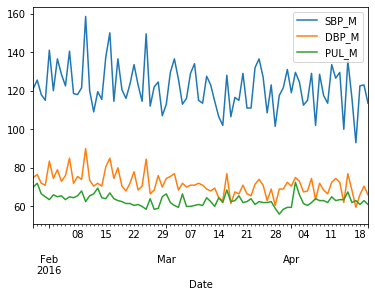

In [35]:
test_all[test_all['Name'].isin(['N/Predict 0097'])][260:344].plot(x = 'Date', y = ['SBP_M', 'DBP_M', 'PUL_M'])

In [36]:
day_param = 84
#df_bp_gr = test_all.groupby(by = ['Name','Date'], as_index = False, observed = True).mean()
df_bp_gr = test_all.set_index('Date')
#df_bp_gr = df_bp_gr.groupby(['Name'], as_index=False).resample(str(day_param)+'D', label='left').apply(list)
#df_bp_gr = df_bp_gr.reset_index(drop = True)

In [37]:
df_bp_gr = df_bp_gr.groupby(['Name'], as_index=False).resample(str(day_param)+'D', label='left').apply(list)
df_bp_gr = df_bp_gr.reset_index(drop = True)

In [38]:
target_df = []
for col_name in df_bp_gr.columns:
    target_df.append(
        pd.DataFrame(
            [ row for row in df_bp_gr[col_name][:]],
            columns = [col_name + str(i+1) for i in range(day_param)]
        )
    )
target_df = pd.concat(target_df, axis = 1)

In [39]:
target_df['Name'] = target_df['Name1']
target_df.drop(
    labels = target_df.loc[:,'Name1':'Name84'].columns.tolist(), 
    axis = 1, 
    inplace = True
)
target_df.dropna(inplace = True)

## Determine labels

In [40]:
target_df['msbp'] = target_df.loc[:, 'SBP_M1':'SBP_M84'].mean(axis = 1)
target_df['mdbp'] = target_df.loc[:, 'DBP_M1':'DBP_M84'].mean(axis = 1)
target_df.reset_index(inplace = True, drop = True)

In [41]:
target_df['labels'] = 0
s_hyflag = target_df['msbp'] >= 135
target_df.loc[s_hyflag == True, 'labels'] = int(1)

d_hyflag = target_df['mdbp'] >= 85
target_df.loc[d_hyflag == True, 'labels'] = int(2)

sd_hyflag = np.logical_and( target_df['msbp'] >= 135, target_df['mdbp'] >= 85)
target_df.loc[sd_hyflag == True, 'labels'] = int(3)


In [42]:
target_df_arr = target_df.iloc[:, :-4].values.reshape(
    len(target_df), 
    len(target_df.iloc[:, :-4].columns) // day_param, 
    day_param
).transpose(0,2,1)

In [43]:
target_df_arr.shape

(3173, 84, 6)

## Wirte Data

In [44]:
np.savez('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data_84.npz',x = target_df_arr, y = target_df['labels'].values)

In [45]:
target_df['labels'].value_counts()

0    2064
1     428
3     349
2     332
Name: labels, dtype: int64

In [46]:
target_df_arr

array([[[ 76.5,  85. ,  71.5,  69. , 130. , 155.5],
        [ 86.5,  90.5,  71. ,  74. , 154. , 159. ],
        [ 73. ,  75. ,  65.5,  67. , 123. , 122. ],
        ...,
        [ 76. ,  80.5,  71.5,  81. , 117. , 140. ],
        [ 76. ,  84.5,  71.5,  76.5, 117. , 143.5],
        [ 71. ,  77.5,  70.5,  71. , 112. , 136. ]],

       [[ 75.5,  76. ,  67. ,  75.5, 124. , 126. ],
        [ 75.5,  79.5,  73. ,  81.5, 112.5, 132. ],
        [ 74. ,  79.5,  76.5,  76. , 111. , 134. ],
        ...,
        [ 75.5,  76.5,  70.5,  67.5, 134.5, 123. ],
        [ 71.5,  78.5,  67. ,  71.5, 131. , 139. ],
        [ 82. ,  81. ,  67. ,  69. , 141. , 144. ]],

       [[ 76. ,  81. ,  67. ,  74.5, 133.5, 138. ],
        [ 74. ,  75.5,  65.5,  70. , 128. , 128.5],
        [ 72.5,  75. ,  66. ,  69.5, 118. , 131.5],
        ...,
        [ 76.5,  78. ,  61.5,  72.5, 133.5, 132. ],
        [ 75.5,  77.5,  62. ,  71.5, 130.5, 141. ],
        [ 70.5,  80. ,  68. ,  64.5, 124. , 143.5]],

       ...,

      